# Week 5 Exploratory Data Analysis
###Dataset: BankWages from RDatasets
###Liam McKenzie

In [1]:
#Set imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
sns.set()

In [2]:
#Get data set and show head
url = "https://vincentarelbundock.github.io/Rdatasets/csv/AER/BankWages.csv" # the URL
bankDF = pd.read_csv(url)
bankDF.head()

,rownames,job,education,gender,minority
0,1,manage,15,male,no
1,2,admin,16,male,no
2,3,admin,12,female,no
3,4,admin,8,female,no
4,5,admin,15,male,no


In [3]:
#Drop ['rownames'] column
bankDF.drop(columns=['rownames']).head()

,job,education,gender,minority
0,manage,15,male,no
1,admin,16,male,no
2,admin,12,female,no
3,admin,8,female,no
4,admin,15,male,no


## Part I: Exploratory Data Analysis

### 1. Modality Analysis - Uni- vs Multimodal



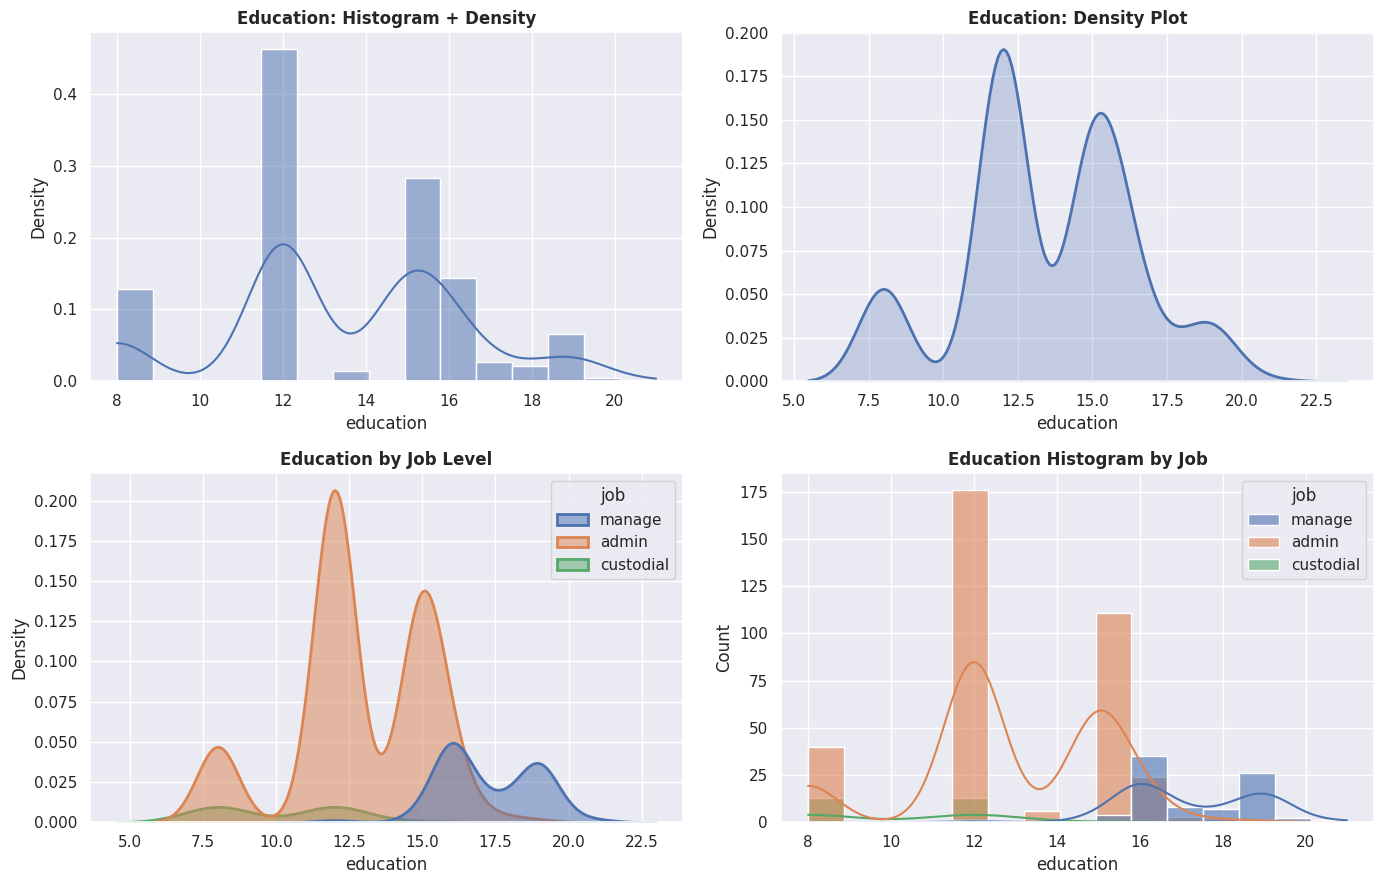

In [4]:
targetCol = 'job'

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

sns.histplot(bankDF['education'], kde=True, stat="density", bins=15, ax=axes[0, 0])
axes[0, 0].set_title('Education: Histogram + Density', fontweight='bold')

sns.kdeplot(bankDF['education'], ax=axes[0, 1], linewidth=2, fill=True)
axes[0, 1].set_title('Education: Density Plot', fontweight='bold')

sns.kdeplot(data=bankDF, x='education', hue='job', ax=axes[1, 0],
            linewidth=2, fill=True, alpha=0.5)
axes[1, 0].set_title('Education by Job Level', fontweight='bold')

sns.histplot(data=bankDF, x='education', hue='job', kde=True,
             ax=axes[1, 1], bins=15, alpha=0.6)
axes[1, 1].set_title('Education Histogram by Job', fontweight='bold')

plt.tight_layout()
plt.show()

This dataset appears to be multimodal. Distinct groups appear for each job type at different education levels.

### 2. Cluster Identification

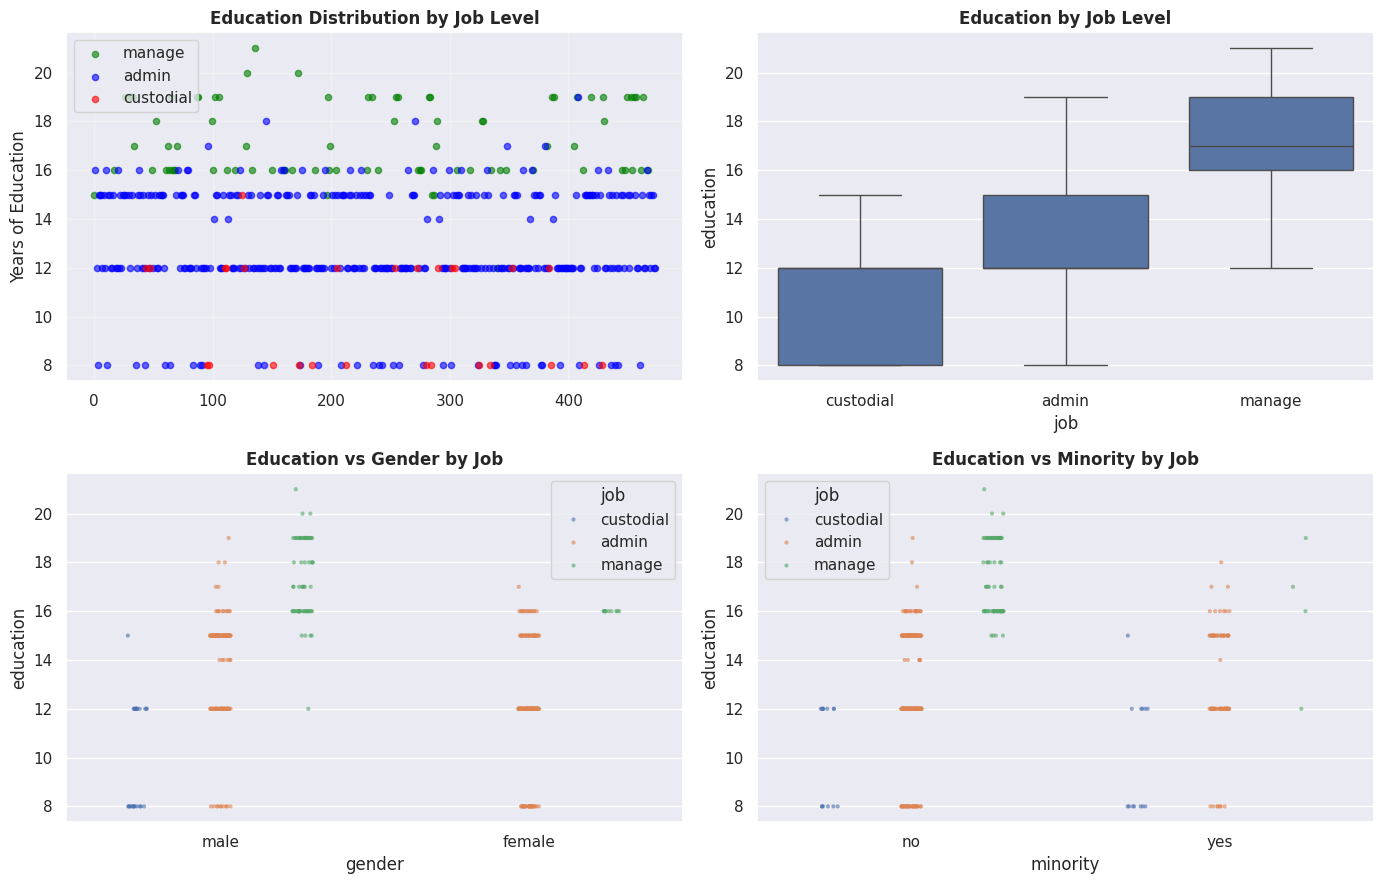

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# Scatter colored by job
jobColors = {'custodial': 'red', 'admin': 'blue', 'manage': 'green'}
for jobLevel in bankDF['job'].unique():
    mask = bankDF['job'] == jobLevel
    axes[0, 0].scatter(bankDF[mask].index, bankDF[mask]['education'],
                      c=jobColors[jobLevel], label=jobLevel, alpha=0.6, s=20)
axes[0, 0].set_title('Education Distribution by Job Level', fontweight='bold')
axes[0, 0].set_ylabel('Years of Education')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

sns.boxplot(data=bankDF, x='job', y='education', ax=axes[0, 1],
            order=['custodial', 'admin', 'manage'])
axes[0, 1].set_title('Education by Job Level', fontweight='bold')

sns.stripplot(data=bankDF, x='gender', y='education', hue='job',
             ax=axes[1, 0], alpha=0.6, dodge=True, size=3,
             hue_order=['custodial', 'admin', 'manage'])
axes[1, 0].set_title('Education vs Gender by Job', fontweight='bold')

sns.stripplot(data=bankDF, x='minority', y='education', hue='job',
             ax=axes[1, 1], alpha=0.6, dodge=True, size=3,
             hue_order=['custodial', 'admin', 'manage'])
axes[1, 1].set_title('Education vs Minority by Job', fontweight='bold')

plt.tight_layout()
plt.show()

Clusters are very clear and intuitive given the context of the dataset. Higher education levels lead to higher tier jobs.

### 3. Target Variable Balance

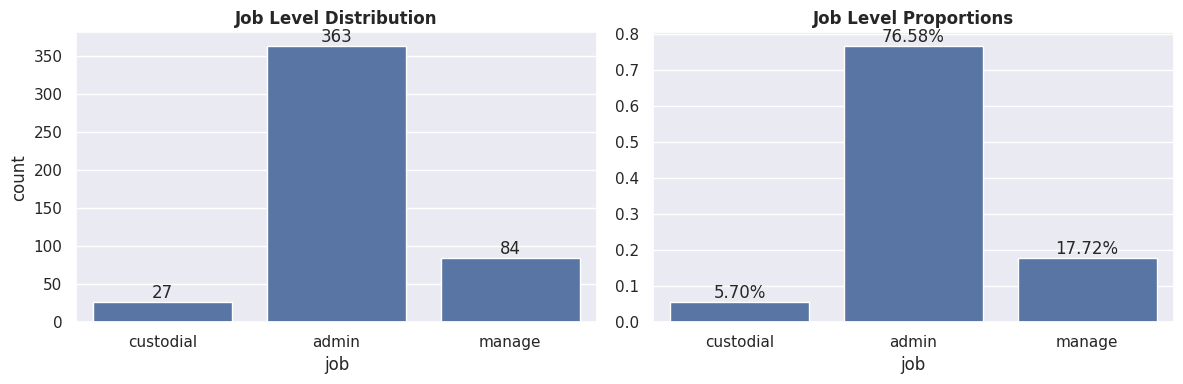

Balance ratio (max/min): 13.444


In [6]:
classCounts = bankDF[targetCol].value_counts()
balanceRatio = classCounts.max() / classCounts.min()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(data=bankDF, x=targetCol, ax=axes[0],
             order=['custodial', 'admin', 'manage'])
axes[0].set_title('Job Level Distribution', fontweight='bold')
for container in axes[0].containers:
    axes[0].bar_label(container)

classProps = classCounts / classCounts.sum()
sns.barplot(x=classProps.index, y=classProps.values, ax=axes[1],
           order=['custodial', 'admin', 'manage'])
axes[1].set_title('Job Level Proportions', fontweight='bold')
for i, job in enumerate(['custodial', 'admin', 'manage']):
    if job in classProps.index:
        axes[1].text(i, classProps[job], f'{classProps[job]:.2%}',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Balance ratio (max/min): {balanceRatio:.3f}")

This data set is very imbalanced. Without balancing it with class weighting or resampling (which isn't possible in this case), a decision tree would heavily favor 'admin' classification for job prediction.

#Part 2 - Modeling

In [7]:
#Encode features
bankFeatures = pd.DataFrame()
bankFeatures["education"] = bankDF["education"]

leGender = LabelEncoder()
bankFeatures["gender"] = leGender.fit_transform(bankDF["gender"])

leMinority = LabelEncoder()
bankFeatures["minority"] = leMinority.fit_transform(bankDF["minority"])

# Encode target
leJob = LabelEncoder()
bankTarget = leJob.fit_transform(bankDF[targetCol])

featureNames = ["education", "gender", "minority"]

In [8]:
#Train/Test split setup for decision tree
#Set test size to 30% of the data and maintain random state to 42 (HGTTG reference!)
bankTrain, bankTest, jobTrain, jobTest = train_test_split(
    bankFeatures, bankTarget, test_size=0.3, random_state=42, stratify=bankTarget
)
#Output sample sizes and target classes
print(f"Training samples: {bankTrain.shape[0]}, Test samples: {bankTest.shape[0]}")
print(f"Target classes: {leJob.classes_}")

Training samples: 331, Test samples: 143
Target classes: ['admin' 'custodial' 'manage']


#Unrestricted Tree
### Baseline Tree

In [9]:
treeFull = DecisionTreeClassifier(criterion="entropy", random_state=42)
treeFull.fit(bankTrain, jobTrain)

jobPredFull = treeFull.predict(bankTest)
accFull = accuracy_score(jobTest, jobPredFull)
print(f"\nUnrestricted Accuracy: {accFull:.4f} ({accFull*100:.2f}%)")
print(f"Depth: {treeFull.get_depth()}, Leaves: {treeFull.get_n_leaves()}")


Unrestricted Accuracy: 0.9021 (90.21%)
Depth: 6, Leaves: 18


#Simplified Tree
Using accuracy score (accFull) from unrestricted tree.

In [10]:
targetAcc = 0.8 * accFull
simpleTree = None
simpleDepth = None

for depth in range(1, treeFull.get_depth() + 1):
    model = DecisionTreeClassifier(criterion="entropy", max_depth=depth, random_state=42)
    model.fit(bankTrain, jobTrain)
    acc = accuracy_score(jobTest, model.predict(bankTest))
    if acc >= targetAcc:
        simpleTree = model
        simpleDepth = depth
        break

print(f"Simplified model found at depth {simpleDepth} with accuracy {acc:.4f} ({acc*100:.2f}%)")


Simplified model found at depth 1 with accuracy 0.8811 (88.11%)


In [11]:
print("Unrestricted Tree Report")
print(classification_report(jobTest, jobPredFull, target_names=leJob.classes_))

print("Simplified Tree Report")
jobPredSimple = simpleTree.predict(bankTest)
print(classification_report(jobTest, jobPredSimple, target_names=leJob.classes_))

Unrestricted Tree Report
              precision    recall  f1-score   support

       admin       0.94      0.94      0.94       110
   custodial       0.57      0.50      0.53         8
      manage       0.85      0.88      0.86        25

    accuracy                           0.90       143
   macro avg       0.78      0.77      0.78       143
weighted avg       0.90      0.90      0.90       143

Simplified Tree Report
              precision    recall  f1-score   support

       admin       0.91      0.94      0.92       110
   custodial       0.00      0.00      0.00         8
      manage       0.77      0.92      0.84        25

    accuracy                           0.88       143
   macro avg       0.56      0.62      0.59       143
weighted avg       0.84      0.88      0.86       143



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Note: precision is the main factor being looked at here. Recall, F1-Score, and Support are also automatically included in sklearn classification_report.

A quick breakdown of each datapoint in the report:
* Precision - how many times the model was correct
* Recall - how many items did the model identify correctly
* F1-Score - balanced score that combines precision and recall
* Support - actual number of items belonging to the category jobTest
* Macro Avg - unweighted mean of metrics across all classes in the dataset
* Weighted Avg - mean of metric weighted by class support



#Including visual breakdown of each tree
This helps to determine decision splits

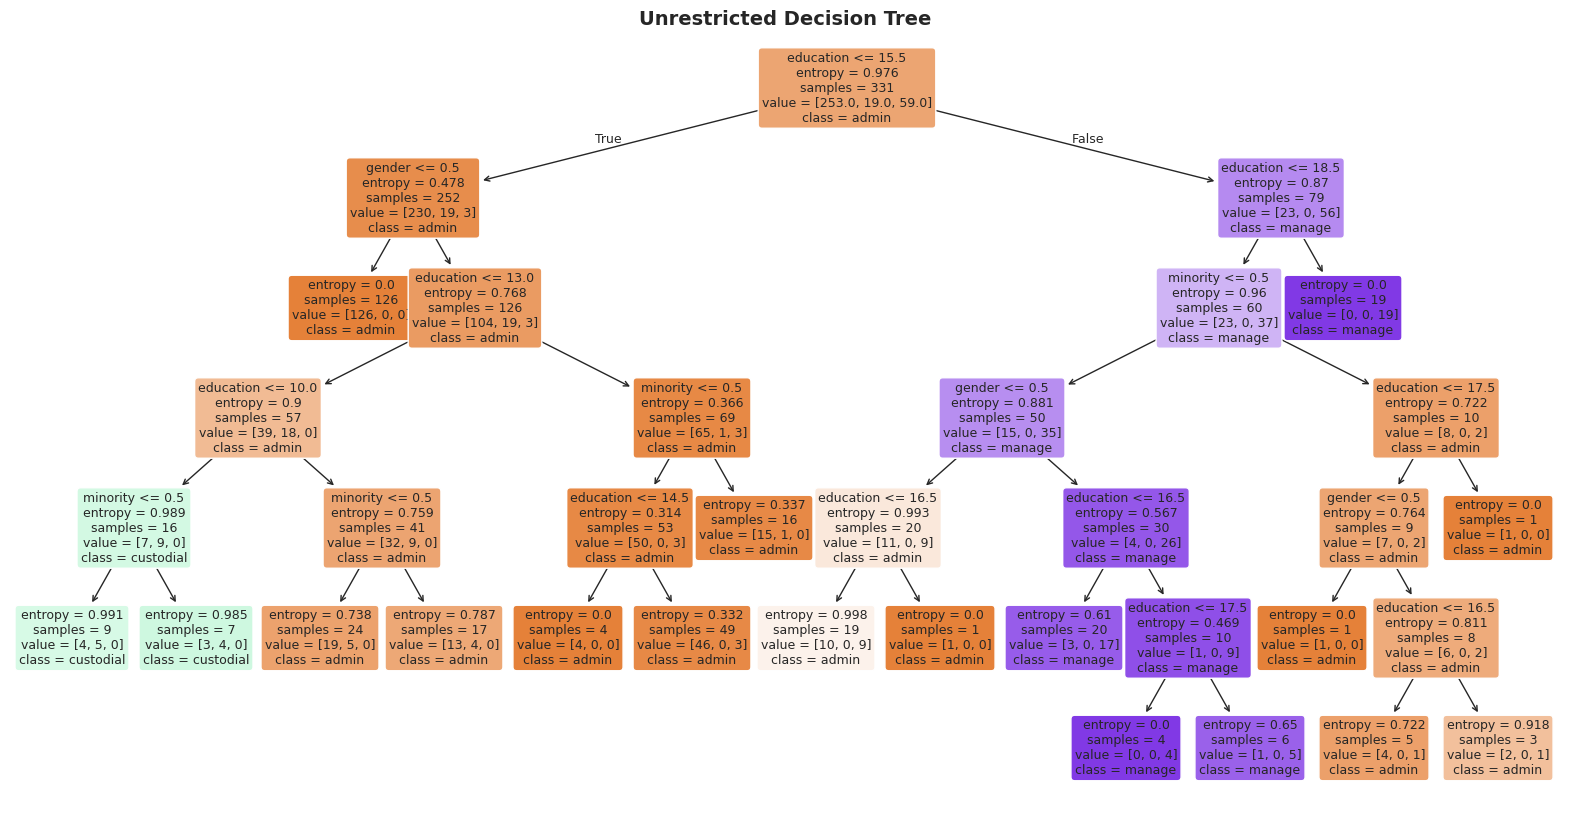

In [12]:
plt.figure(figsize=(20, 10))
plot_tree(
    treeFull,
    feature_names=featureNames,
    class_names=leJob.classes_,
    filled=True,
    rounded=True,
    fontsize=9
)
plt.title("Unrestricted Decision Tree", fontsize=14, fontweight="bold")
plt.show()




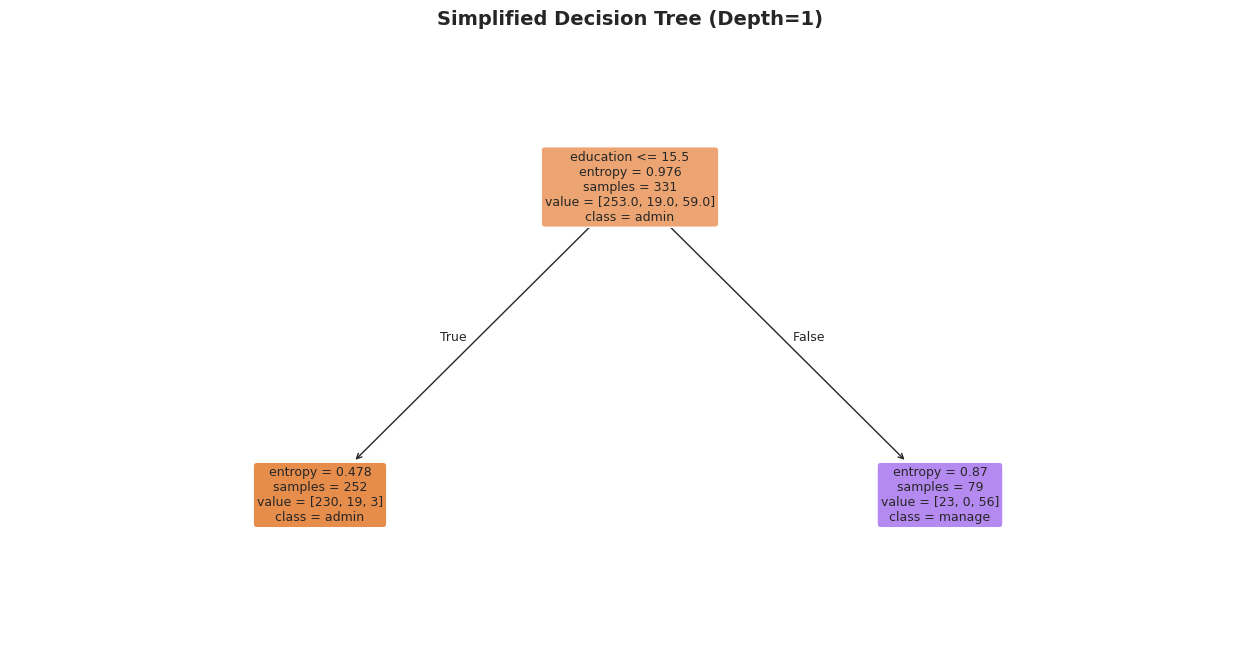

In [13]:
plt.figure(figsize=(16, 8))
plot_tree(
        simpleTree,
        feature_names=featureNames,
        class_names=leJob.classes_,
        filled=True,
        rounded=True,
        fontsize=9
    )
plt.title(f"Simplified Decision Tree (Depth={simpleDepth})", fontsize=14, fontweight="bold")
plt.show()

Both unrestricted and simplified models appear to agree on the major classifications of this dataset. The splits are intuitive given data domain. Since the dataset tracks education vs job level, the higher the education, the higher the job position, seems to hold true.  

# Simplified Model plot via Seaborn

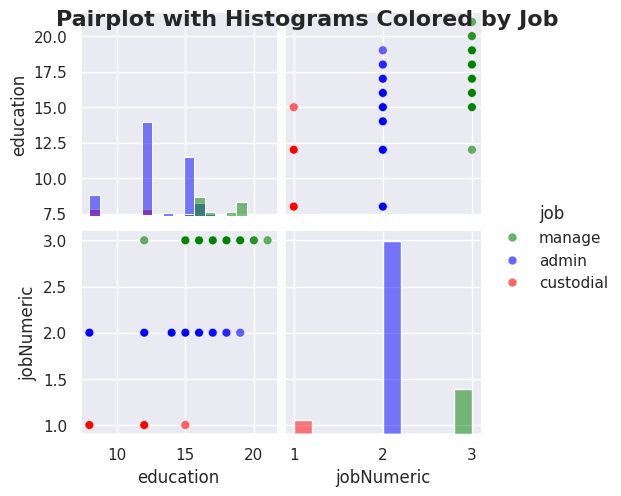

In [15]:

# Map job to numeric for axis scaling (optional)
jobMapping = {'custodial': 1, 'admin': 2, 'manage': 3}
bankDF['jobNumeric'] = bankDF['job'].map(jobMapping)

# Numeric features including jobNumeric
plotCols = ['education', 'jobNumeric']

# Create pairplot with histograms on the diagonal and colored by job
sns.pairplot(bankDF[plotCols + ['job']],
             hue='job',
             palette={'custodial': 'red', 'admin': 'blue', 'manage': 'green'},
             diag_kind='hist',
             plot_kws={'alpha': 0.6, 's': 40})

plt.suptitle("Pairplot with Histograms Colored by Job", fontsize=16, fontweight='bold')
plt.show()


Pairplot was necessary in this case because there were conflicting artifacts with scattermatrix formatting. For readability a pairplot was chosen. Also, due to lack of numerical data in this set, mapping each job, custodial, admin, manage, to a number (1,2,3) allowed for a visual representation on a scatter plot.

The decison tree splits can be seen easily in both histogram and scatter plot. The large blue bars and points represent a higher propensity to select 'admin' over anything else, which makes sense, given the number of 'admin' data points in the dataset.